In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [2]:
class MyRandomForestClassifier:
    def __init__(self, n_estimators=100, criterion='gini',
                 max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                 max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_impurity_split=None, bootstrap=True, random_state=None, max_samples=None):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.max_samples = max_samples

        self.estimators = []
        for i in range(self.n_estimators):
            self.estimators.append(
                DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth,
                                       min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf,
                                       min_weight_fraction_leaf=self.min_weight_fraction_leaf,
                                       max_features=self.max_features,
                                       max_leaf_nodes=self.max_leaf_nodes,
                                       min_impurity_decrease=self.min_impurity_decrease,
                                       random_state=self.random_state))

    def fit(self, x, y):
        samples_count = x.shape[0]
        if self.max_samples is not None:
            samples_count = self.max_samples

        bootstrapped_x = pd.DataFrame()
        bootstrapped_y = pd.DataFrame()

        bootstrapped_rows = np.random.choice(x.shape[0], samples_count, replace=self.bootstrap)
        bootstrapped_x = x.iloc[bootstrapped_rows]
        bootstrapped_y = y.iloc[bootstrapped_rows]

        for clf in self.estimators:
            clf.fit(bootstrapped_x, bootstrapped_y)

    def predict(self, x):
        ones = [0 for i in range(x.shape[0])]

        for i, clf in enumerate(self.estimators):
            predictions = list(clf.predict(x))
            for val in predictions:
                if val == 1:
                    ones[i] += 1
        return pd.Series(ones)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.shape

(957919, 120)

In [6]:
test.shape

(493474, 119)

In [7]:
train.head(10)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.251000,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.017700,1
1,1,0.100900,0.299610,11822.000,0.276500,0.459700,-0.837330,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.283590,0
2,2,0.178030,-0.006980,907.270,0.272140,0.459480,0.173270,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.406900,1
3,3,0.152360,0.007259,780.100,0.025179,0.519470,7.491400,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.514860,1
4,4,0.116230,0.502900,-109.150,0.297910,0.344900,-0.409320,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.230490,1
5,5,0.101530,-0.002612,-1118.700,0.116300,0.318860,-0.478390,2372.80,-1808.0,5.818100e+15,...,-44.0820,3.5812,26.55900,-6.47220,44570.00,1.1776,2.997700e+14,5548.3,-0.033159,0
6,6,0.003073,0.359530,20913.000,0.003465,0.268060,-1.225100,1301.20,233180.0,1.771400e+15,...,-39.9220,1.4896,1.29230,33.63400,16201.00,1.2271,2.458900e+16,1012.9,0.647970,0
7,7,0.097340,0.245910,11775.000,0.614860,0.479370,-1.486500,3179.20,123940.0,1.652900e+15,...,-22.9950,1.5719,101.95000,1.51560,1117.50,1.2468,-6.971300e+13,1481.7,0.303170,1
8,8,-0.008948,0.338020,503.810,0.601520,0.261760,0.735380,1614.00,408030.0,7.684400e+14,...,-9.5142,2.2176,-1.23750,7.07130,1030.80,1.2040,5.290300e+15,1968.1,0.145930,0
9,9,0.126230,0.173960,1662.000,0.038081,0.000485,0.059909,296.07,-8035.3,4.526300e+15,...,-1.9684,3.9595,19.16900,-0.24498,838.39,1.1968,2.567000e+17,4914.9,0.519760,0


<AxesSubplot:>

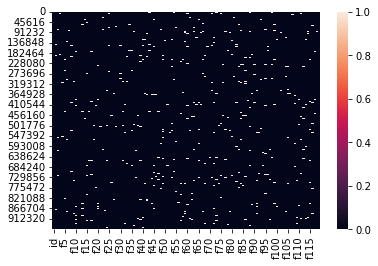

In [8]:
sns.heatmap(train.isna())

<AxesSubplot:>

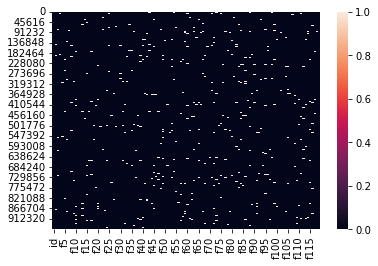

In [11]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

impured_train = pd.DataFrame(imp_mean.fit_transform(train), columns=train.columns)
impured_test = pd.DataFrame(imp_mean.fit_transform(test), columns=test.columns)

sns.heatmap(train.isna())

<AxesSubplot:>

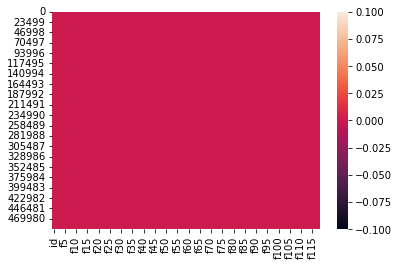

In [12]:
sns.heatmap(impured_test.isna())

In [13]:
impured_train.head(10)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0.0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.251000,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.100000,1.017700,1.0
1,1.0,0.100900,0.299610,11822.000,0.276500,0.459700,-0.837330,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.000000,0.283590,0.0
2,2.0,0.178030,-0.006980,907.270,0.272140,0.459480,0.173270,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.200000,0.406900,1.0
3,3.0,0.152360,0.007259,780.100,0.025179,0.519470,7.491400,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.100000,0.514860,1.0
4,4.0,0.116230,0.502900,-109.150,0.297910,0.344900,-0.409320,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3959.204669,0.230490,1.0
5,5.0,0.101530,-0.002612,-1118.700,0.116300,0.318860,-0.478390,2372.80,-1808.0,5.818100e+15,...,-44.0820,3.5812,26.55900,-6.47220,44570.00,1.1776,2.997700e+14,5548.300000,-0.033159,0.0
6,6.0,0.003073,0.359530,20913.000,0.003465,0.268060,-1.225100,1301.20,233180.0,1.771400e+15,...,-39.9220,1.4896,1.29230,33.63400,16201.00,1.2271,2.458900e+16,1012.900000,0.647970,0.0
7,7.0,0.097340,0.245910,11775.000,0.614860,0.479370,-1.486500,3179.20,123940.0,1.652900e+15,...,-22.9950,1.5719,101.95000,1.51560,1117.50,1.2468,-6.971300e+13,1481.700000,0.303170,1.0
8,8.0,-0.008948,0.338020,503.810,0.601520,0.261760,0.735380,1614.00,408030.0,7.684400e+14,...,-9.5142,2.2176,-1.23750,7.07130,1030.80,1.2040,5.290300e+15,1968.100000,0.145930,0.0
9,9.0,0.126230,0.173960,1662.000,0.038081,0.000485,0.059909,296.07,-8035.3,4.526300e+15,...,-1.9684,3.9595,19.16900,-0.24498,838.39,1.1968,2.567000e+17,4914.900000,0.519760,0.0


In [15]:
impured_train_X = impured_train.iloc[:, 1:-1]
impured_test_X = impured_test.iloc[:, 1:]

impured_train_y = pd.DataFrame(impured_train.iloc[:, 119])

impured_train_X.head(10)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.251000,135.12,168900.0,3.992400e+14,86.489,...,0.110930,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.100000,1.017700
1,0.100900,0.299610,11822.000,0.276500,0.459700,-0.837330,1721.90,119810.0,3.874100e+15,9953.600,...,0.976730,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.000000,0.283590
2,0.178030,-0.006980,907.270,0.272140,0.459480,0.173270,2298.00,360650.0,1.224500e+13,15827.000,...,0.201020,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.200000,0.406900
3,0.152360,0.007259,780.100,0.025179,0.519470,7.491400,112.51,259490.0,7.781400e+13,-36.837,...,-0.011820,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.100000,0.514860
4,0.116230,0.502900,-109.150,0.297910,0.344900,-0.409320,2538.90,65332.0,1.907200e+15,144.120,...,0.927390,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3959.204669,0.230490
5,0.101530,-0.002612,-1118.700,0.116300,0.318860,-0.478390,2372.80,-1808.0,5.818100e+15,8421.200,...,0.523080,-44.0820,3.5812,26.55900,-6.47220,44570.00,1.1776,2.997700e+14,5548.300000,-0.033159
6,0.003073,0.359530,20913.000,0.003465,0.268060,-1.225100,1301.20,233180.0,1.771400e+15,-48.087,...,0.550650,-39.9220,1.4896,1.29230,33.63400,16201.00,1.2271,2.458900e+16,1012.900000,0.647970
7,0.097340,0.245910,11775.000,0.614860,0.479370,-1.486500,3179.20,123940.0,1.652900e+15,504.400,...,0.242270,-22.9950,1.5719,101.95000,1.51560,1117.50,1.2468,-6.971300e+13,1481.700000,0.303170
8,-0.008948,0.338020,503.810,0.601520,0.261760,0.735380,1614.00,408030.0,7.684400e+14,5.382,...,0.307160,-9.5142,2.2176,-1.23750,7.07130,1030.80,1.2040,5.290300e+15,1968.100000,0.145930
9,0.126230,0.173960,1662.000,0.038081,0.000485,0.059909,296.07,-8035.3,4.526300e+15,-90.304,...,0.007485,-1.9684,3.9595,19.16900,-0.24498,838.39,1.1968,2.567000e+17,4914.900000,0.519760


In [17]:
train_X, valid_X, train_y, valid_y = train_test_split(impured_train_X, impured_train_y, test_size=0.33)

train_X.shape

(641805, 118)

In [18]:
train_X.head(10)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
140786,0.130070,0.343750,4068.744207,0.422360,0.25482,-6.045000,316.43,109190.000000,6.644000e+13,974.6700,...,0.50484,-16.3790,1.71960,0.86504,5.747800,799.59,1.1730,9.066000e+16,4796.20,0.68607
604889,0.095797,0.140870,2259.000000,0.211540,0.28138,-5.339000,22.43,358790.000000,6.581200e+15,2398.1000,...,0.46615,-32.1360,2.86870,-0.12325,-8.782400,5972.30,1.3045,1.588600e+16,6555.40,0.86216
813332,0.077648,0.216980,265.770000,0.040527,0.33122,1.120100,4371.00,544080.000000,7.537500e+15,16865.0000,...,1.00690,-18.6910,1.51770,1.67870,-1.663600,2584.80,1.2717,7.113100e+16,7912.90,1.26800
26713,0.111680,0.447040,4305.000000,0.218770,0.49838,0.055513,2276.40,324000.000000,2.630700e+15,6885.9000,...,0.24168,-13.9690,1.61420,1.52160,-18.275000,223680.00,1.1614,7.645800e+15,1431.80,1.37000
669083,0.001393,0.485460,586.970000,0.463880,0.36208,0.225150,3302.30,377164.164157,2.487600e+14,-3.2076,...,0.47235,-9.2530,2.92150,9.14280,-7.908600,43508.00,1.1925,2.553300e+16,2106.60,0.31287
705499,0.071649,0.415410,4556.600000,-0.005050,0.39109,0.951530,4059.60,997480.000000,8.016500e+15,49059.0000,...,0.57995,-59.5410,1.52360,-2.15390,-0.034736,110330.00,1.2038,3.313100e+16,12149.00,0.33645
770262,0.004432,0.479460,-1186.700000,0.246350,0.46951,0.736540,535.80,536760.000000,2.067700e+14,3031.9000,...,0.52255,-3.2999,2.07453,0.23915,11.051000,202870.00,1.1842,-2.206400e+14,269.39,0.26639
738445,-0.033294,0.004456,5994.700000,0.244820,0.40733,-0.609660,3863.50,829680.000000,1.782000e+14,12565.0000,...,0.52656,-2.1180,3.96320,2.23700,-0.352980,14302.00,1.1906,3.244200e+16,11926.00,0.86107
126795,0.089835,0.491680,347.190000,0.420000,0.48844,0.943030,1888.00,19794.000000,1.998700e+15,2947.4000,...,0.24124,-21.7610,1.61500,-2.37440,-2.393200,54509.00,1.1236,4.276905e+16,138.26,0.75023
143790,0.144270,0.426330,16956.000000,0.338030,0.47694,-0.106810,2857.80,262830.000000,1.806054e+15,1940.1000,...,0.54201,-3.8196,1.51110,-0.83431,4.610500,2272.20,1.2821,4.276905e+16,1970.60,0.39276


In [19]:
train_y.head(10)

,claim
140786,1.0
604889,0.0
813332,0.0
26713,0.0
669083,1.0
705499,1.0
770262,0.0
738445,1.0
126795,1.0
143790,1.0


In [20]:
train_y.shape

(641805, 1)

In [22]:
my_rfc = MyRandomForestClassifier(n_estimators=5, bootstrap=True, max_samples=1000)

my_rfc.fit(train_X, train_y)

In [25]:
y_pred = my_rfc.predict(valid_X)

accuracy_score(valid_y, y_pred)

0.5012274053031501

In [28]:
sklearn_rfc = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                     max_depth=None, min_samples_split=2, 
                                     min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                     max_features='auto', max_leaf_nodes=None, 
                                     min_impurity_decrease=0.0,
                                     bootstrap=True, random_state=None, max_samples=None, verbose=2)

sklearn_rfc.fit(train_X, np.ravel(train_y))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.5min finished


RandomForestClassifier(verbose=2)

In [30]:
y_pred = sklearn_rfc.predict(valid_X)

accuracy_score(valid_y, y_pred)

0.543253383273123

In [32]:
lightgbm_rfc = LGBMClassifier(n_estimators=100, criterion='gini', 
                              max_depth=None, min_samples_split=2, 
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                              max_features='auto', max_leaf_nodes=None, 
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              bootstrap=True, random_state=None, max_samples=None, verbose=0)

lightgbm_rfc.fit(train_X, np.ravel(train_y))

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105624 seconds.
You can set `force_col_wise=true` to remove the overhead.


LGBMClassifier(bootstrap=True, criterion='gini', max_depth=None,
               max_features='auto', max_leaf_nodes=None, max_samples=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, verbose=0)

In [34]:
y_pred = lightgbm_rfc.predict(valid_X)

accuracy_score(valid_y, y_pred)

0.6980677856722575

In [35]:
params = {
    'n_estimators': range(1, 300),
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 50),
    'min_samples_leaf': range(1, 100),
    'max_leaf_nodes': range(10, 200),
    'max_samples': range(10, 10000)
}

In [37]:
clf = RandomizedSearchCV(lightgbm_rfc, params, cv=5, verbose=2)

clf.fit(train_X, np.ravel(train_y))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[CV] END max_depth=6, max_leaf_nodes=150, max_samples=1440, min_samples_leaf=58, min_samples_split=13, n_estimators=164; total time=  10.6s
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[CV] END max_depth=2, max_leaf_nodes=112, max_samples=714, min_samples_leaf=34, min_samples_split=36, n_estimators=175; total time=   5.6s
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] 

[CV] END max_depth=3, max_leaf_nodes=43, max_samples=4738, min_samples_leaf=48, min_samples_split=7, n_estimators=299; total time=  10.1s
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END max_depth=4, max_leaf_nodes=161, max_samples=366, min_samples_leaf=74, min_samples_split=21, n_estimators=204; total time=   9.0s
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning

[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[CV] END max_depth=2, max_leaf_nodes=143, max_samples=351, min_samples_leaf=2, min_samples_split=49, n_estimators=192; total time=   6.4s
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] 

[CV] END max_depth=8, max_leaf_nodes=27, max_samples=8216, min_samples_leaf=36, min_samples_split=39, n_estimators=218; total time=  15.3s
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_s

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(bootstrap=True, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            verbose=0),
                   param_distributions={'max_depth': range(1, 10),
                                        'max_leaf_nodes': range(10, 200),
                                        'max_samples': range(10, 10000),
                                        'min_samples_leaf': range(1, 100),
 

In [38]:
clf.best_params_

{'n_estimators': 218,
 'min_samples_split': 39,
 'min_samples_leaf': 36,
 'max_samples': 8216,
 'max_leaf_nodes': 27,
 'max_depth': 8}

In [39]:
my_rfc = MyRandomForestClassifier(**clf.best_params_, bootstrap=True)
my_rfc.fit(train_X, train_y)

In [40]:
sklearn_rfc = RandomForestClassifier(**clf.best_params_, verbose=2, bootstrap=True)
sklearn_rfc.fit(train_X, np.ravel(train_y))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 218
building tree 2 of 218
building tree 3 of 218
building tree 4 of 218
building tree 5 of 218
building tree 6 of 218
building tree 7 of 218
building tree 8 of 218
building tree 9 of 218
building tree 10 of 218
building tree 11 of 218
building tree 12 of 218
building tree 13 of 218
building tree 14 of 218
building tree 15 of 218
building tree 16 of 218
building tree 17 of 218
building tree 18 of 218
building tree 19 of 218
building tree 20 of 218
building tree 21 of 218
building tree 22 of 218
building tree 23 of 218
building tree 24 of 218
building tree 25 of 218
building tree 26 of 218
building tree 27 of 218
building tree 28 of 218
building tree 29 of 218
building tree 30 of 218
building tree 31 of 218
building tree 32 of 218
building tree 33 of 218
building tree 34 of 218
building tree 35 of 218
building tree 36 of 218
building tree 37 of 218
building tree 38 of 218
building tree 39 of 218
building tree 40 of 218
building tree 41 of 218
building tree 42 of 218
b

[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:   17.8s finished


RandomForestClassifier(max_depth=8, max_leaf_nodes=27, max_samples=8216,
                       min_samples_leaf=36, min_samples_split=39,
                       n_estimators=218, verbose=2)

In [41]:
lightgbm_rfc = LGBMClassifier(**clf.best_params_, verbose=2, bootstrap=True)
lightgbm_rfc.fit(train_X, np.ravel(train_y))

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 319850, number of negative: 321955
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.00

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Traine

LGBMClassifier(bootstrap=True, max_depth=8, max_leaf_nodes=27, max_samples=8216,
               min_samples_leaf=36, min_samples_split=39, n_estimators=218,
               verbose=2)

In [42]:
y_pred = my_rfc.predict(valid_X)
accuracy_score(valid_y, y_pred)

0.5009079003144435

In [44]:
y_pred = sklearn_rfc.predict(valid_X)
accuracy_score(valid_y, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    2.8s finished


0.5568623977425865

In [45]:
y_pred = lightgbm_rfc.predict(valid_X)
accuracy_score(valid_y, y_pred)

0.7185192683652101

In [46]:
%timeit my_rfc.predict(impured_test_X)

30.5 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%timeit sklearn_rfc.predict(impured_test_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

4.25 s ± 32.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[Parallel(n_jobs=1)]: Done 218 out of 218 | elapsed:    4.2s finished


In [48]:
%timeit lightgbm_rfc.predict(impured_test_X)

1.43 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
class MyEnsemble:
    def __init__(self, n_estimators=100, criterion='gini',
                 max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                 max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                 min_impurity_split=None, bootstrap=True, random_state=None, max_samples=None):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.max_samples = max_samples

        self.my_rfc = MyRandomForestClassifier(n_estimators=self.n_estimators, criterion=self.criterion, 
                                                         max_depth=self.max_depth, min_samples_split=self.min_samples_split, 
                                                         min_samples_leaf=self.min_samples_leaf, min_weight_fraction_leaf=self.min_weight_fraction_leaf, 
                                                         max_features=self.max_features, max_leaf_nodes=self.max_leaf_nodes, 
                                                         min_impurity_decrease=self.min_impurity_decrease, bootstrap=self.bootstrap, 
                                                         random_state=self.random_state, max_samples=self.max_samples)
        
        self.sklearn_rfc = RandomForestClassifier(n_estimators=self.n_estimators, criterion=self.criterion, 
                                                  max_depth=self.max_depth, min_samples_split=self.min_samples_split, 
                                                  min_samples_leaf=self.min_samples_leaf, min_weight_fraction_leaf=self.min_weight_fraction_leaf, 
                                                  max_features=self.max_features, max_leaf_nodes=self.max_leaf_nodes, 
                                                  min_impurity_decrease=self.min_impurity_decrease, bootstrap=self.bootstrap, 
                                                  random_state=self.random_state, max_samples=self.max_samples)
        
        self.lightgbm_rfc = LGBMClassifier(n_estimators=self.n_estimators, criterion=self.criterion, 
                                           max_depth=self.max_depth, min_samples_split=self.min_samples_split, 
                                           min_samples_leaf=self.min_samples_leaf, min_weight_fraction_leaf=self.min_weight_fraction_leaf, 
                                           max_features=self.max_features, max_leaf_nodes=self.max_leaf_nodes, 
                                           min_impurity_decrease=self.min_impurity_decrease, bootstrap=self.bootstrap, 
                                           random_state=self.random_state, max_samples=self.max_samples)
        
    def fit(self, x, y):
        samples_count = x.shape[0]
        if self.max_samples is not None:
            samples_count = self.max_samples

        bootstrapped_x = pd.DataFrame()
        bootstrapped_y = pd.DataFrame()

        bootstrapped_rows = np.random.choice(x.shape[0], samples_count, replace=self.bootstrap)
        bootstrapped_x = x.iloc[bootstrapped_rows]
        bootstrapped_y = y.iloc[bootstrapped_rows]
        
        self.my_rfc.fit(bootstrapped_x, bootstrapped_y)
        self.sklearn_rfc.fit(bootstrapped_x, np.ravel(bootstrapped_y))
        self.lightgbm_rfc.fit(bootstrapped_x, np.ravel(bootstrapped_y))

    def predict(self, x):
        ones = [0 for i in range(x.shape[0])]

        predictions = list(self.my_rfc.predict(x))
        for i, val in enumerate(predictions):
            ones[i] += val
            
        predictions = list(self.sklearn_rfc.predict(x))
        for i, val in enumerate(predictions):
            ones[i] += val

        predictions = list(self.lightgbm_rfc.predict(x))
        for i, val in enumerate(predictions):
            ones[i] += val
    
        predictions = [1 if x > 1 else 0 for x in ones]
        return pd.Series(predictions)

In [51]:
my_ensemble = MyEnsemble(**clf.best_params_, bootstrap=True)

my_ensemble.fit(train_X, train_y)

[LightGBM] [Warning] Unknown parameter: min_impurity_decrease
[LightGBM] [Warning] Unknown parameter: min_weight_fraction_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_samples
[LightGBM] [Warning] Unknown parameter: max_leaf_nodes
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: criterion


In [52]:
y_pred = my_ensemble.predict(valid_X)

accuracy_score(valid_y, y_pred)

0.5316278304662242